In [4]:
!pip install nilearn==0.9.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import os
import numpy as np
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import matplotlib
from matplotlib import pyplot as plt
from nilearn import datasets
from nilearn import plotting
import torch
from torch.utils.data import DataLoader, Dataset
from torchvision.models.feature_extraction import create_feature_extractor, get_graph_node_names
from torchvision import transforms
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr as corr

import tensorflow_datasets as tfds
import tensorflow as tf

from keras import datasets, Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

from tensorflow.keras.layers.experimental.preprocessing import Resizing

from google.colab import drive
import h5py


import datetime

%load_ext tensorboard

# Load the data

In [6]:
import os
import random
import time

In [7]:
drive.mount('/content/drive', force_remount=True)
os.chdir ("drive/MyDrive")

filename = "/content/drive/MyDrive/miniecoset_100obj_64px.h5"

Mounted at /content/drive


In [8]:
############ STORING ECO DATASET ############

with h5py.File(filename, "r") as f:
    # get all the keys to explore further
    print(f.keys()) 
    # extracting data
    x_train_eco = f['train']['data'][()]
    y_train_eco = f['train']['labels'][()]
    x_test_eco = f['test']['data'][()]
    y_test_eco = f['test']['labels'][()]


<KeysViewHDF5 ['categories', 'dataset_description', 'fasttext_embeddings', 'test', 'train', 'val']>


In [9]:
x_train_eco_short = np.asarray([x_train_eco[index] for index in range(0, len(x_train_eco), 5)])
y_train_eco_short = np.asarray([y_train_eco[index] for index in range(0, len(y_train_eco), 5)])
x_test_eco_short = x_test_eco
y_test_eco_short = y_test_eco

print(len(x_train_eco_short))
print(len(x_test_eco_short))

50000
5000


In [1]:
'''
######## Change length of train & test (so that it matches Cifar100)  ############
a = 4

#
x_train_eco_short = np.asarray([x_train_eco[index] for index in range(0, len(x_train_eco), a)])
y_train_eco_short = np.asarray([y_train_eco[index] for index in range(0, len(y_train_eco), a)])
x_test_eco_short = x_test_eco
y_test_eco_short = y_test_eco

# add 5.000 datapoints to test dataset
x_test_eco_s = np.concatenate((x_test_eco_short, x_train_eco_short[-5000:]))
y_test_eco_s = np.concatenate((y_test_eco_short, y_train_eco_short[-5000:]))

# take 50.000 datapoints for train dataset
x_train_eco_s = x_train_eco_short[:50000]
y_train_eco_s = y_train_eco_short[:50000]

print("len(x_train_eco_s): ", len(x_train_eco_s))
print("len(y_train_eco_s): ", len(y_train_eco_s))
print("len(x_test_eco_s): ", len(x_test_eco_s))
print("len(y_test_eco_s): ", len(y_test_eco_s))

'''

NameError: ignored

In [37]:
print(len(x_train_eco_short))

x_test_eco_short = list(zip(x_test_eco_short, x_train_eco_short[:-5000]))
y_test_eco_short = y_test_eco_short.append(y_train_eco_short[:-5000])

x_train_eco_short = x_train_eco_short[:50000]
y_train_eco_short = y_train_eco_short[:50000]

print(len(x_test_eco_short))
#print(len(y_test_eco_short))
print(len(y_train_eco_short))
print(len(x_train_eco_short))

62500


AttributeError: ignored

# Preprocess data

In [10]:
############# PREPROCESS ################

#desired_size = (32, 32)

def preprocess(x_train_data, x_test_data, dataset_type):

    # convert the 2d array output labels into 1D array
    x_train_data = x_train_data.astype('float32')
    x_test_data = x_test_data.astype('float32')

    # normalizing the training and testing data
    x_train_data /= 255.0
    x_test_data /= 255.0

    if dataset_type == 'eco':

      # Define a Resizing layer to resize the images
      resize_layer = Resizing(32, 32)

      # Apply the Resizing layer to the datasets
      x_train_data = resize_layer(x_train_data)
      x_test_data = resize_layer(x_test_data)

    return x_train_data, x_test_data


############# PREPROCESS DATA #################

x_train_eco, x_test_eco = preprocess(x_train_eco_short, x_test_eco_short, 'eco')


# Visualization

In [11]:
# these are the labels for the cifar10 data set, so 0 means airplane, 1 means automobile and so on
eco_labels = '''man woman child monkey elephant dog pig cat 
            tiger leopard zebra wolf camel kangaroo deer 
            rhino cow goat mouse squirrel bird snake turtle 
            frog spider rabbit alligator cockroach chicken wasp 
            butterfly snail jellyfish worm grasshopper lizard 
            mosquito lobster ant beetle seashell fire apple 
            flower chestnut egg lemon banana fern cactus corn 
            lettuce grape rice onion oyster aloe parsley 
            bubble cherry phone gun book ball clock bag 
            camera cup key pizza bell toilet knife hamburger 
            axe mailbox lamp bread shovel spoon bed table 
            ship bus bridge computer train truck refrigerator 
            airplane lighthouse piano television bicycle windmill 
            barrel canoe cannon hut helicopter'''.split()
            
            

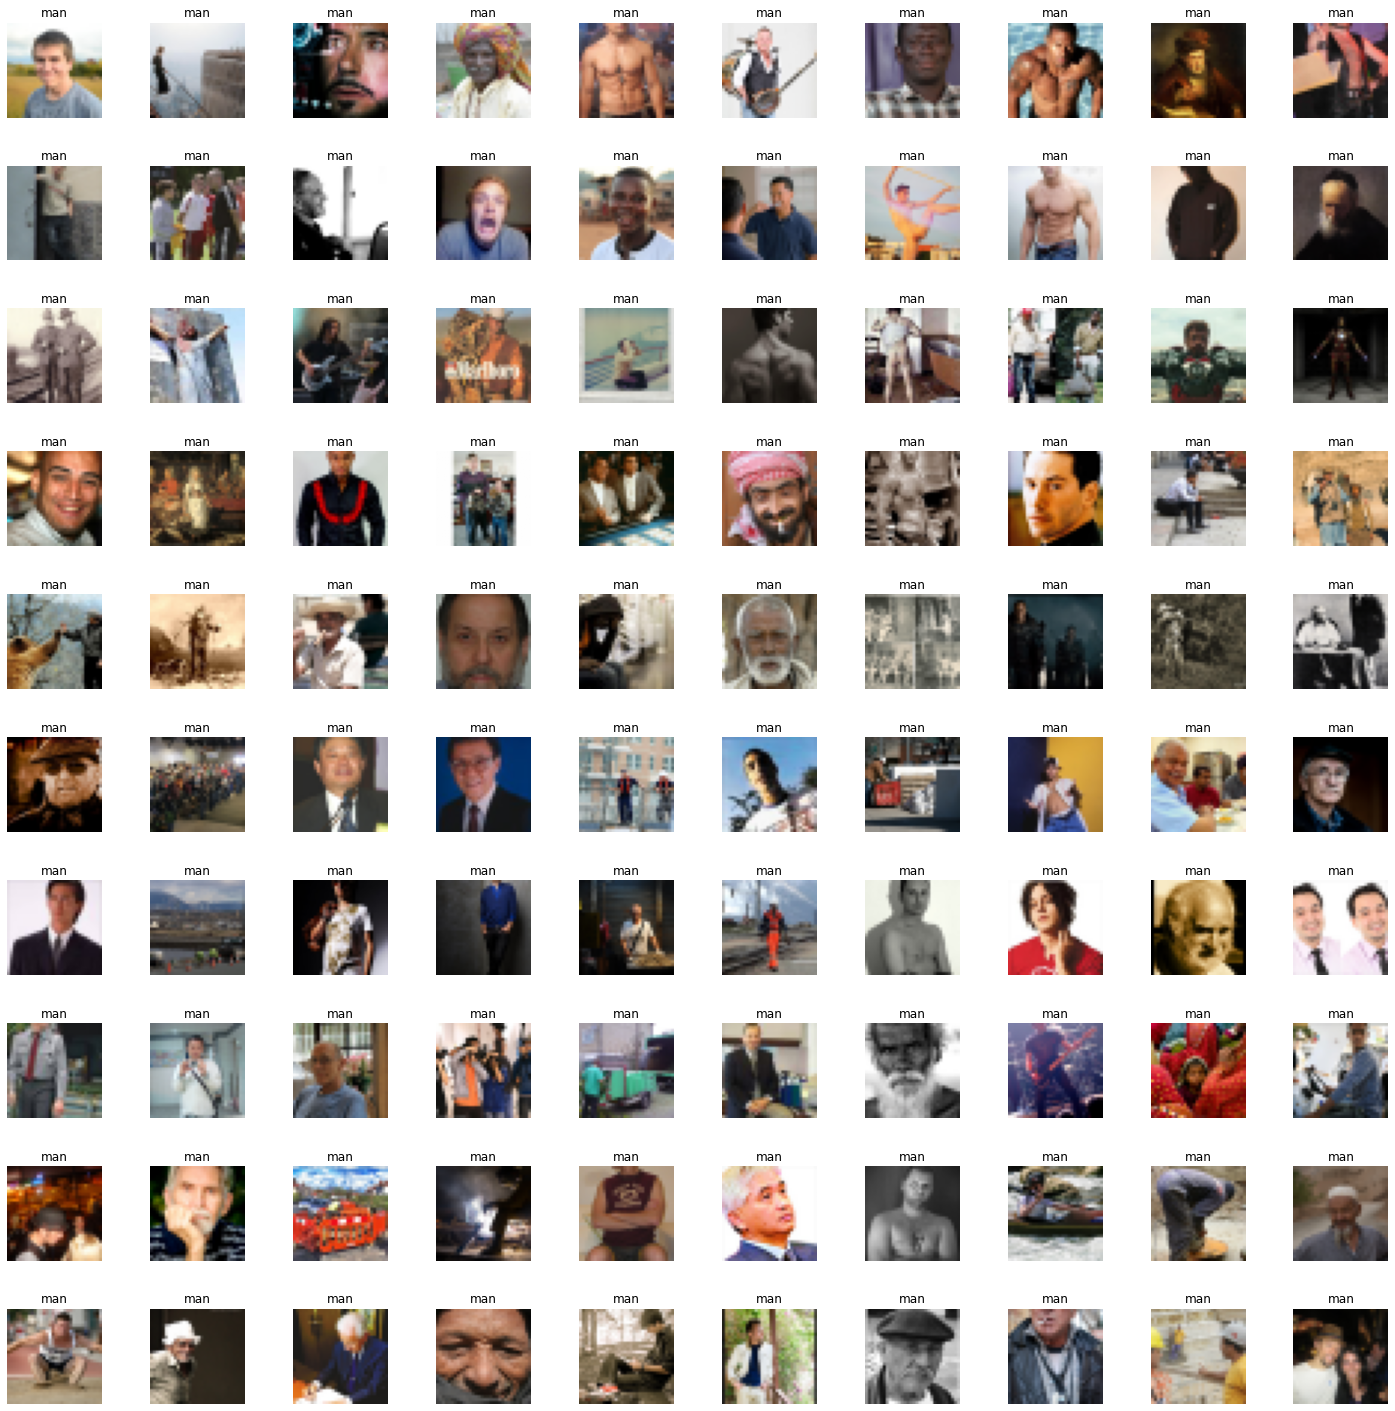

In [13]:
############## VISUALIZE ##################

def visualize(images, y_train, y_labels):
    fig, axes = plt.subplots(10, 10, figsize=(20, 20))
    fig.tight_layout()

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i])
        ax.set_title(y_labels[y_train[i]])
        ax.axis("off")

visualize(x_train_eco, y_train_eco_short, eco_labels)

# CNN Model

In [14]:
############# MODEL ####################

def create_CNN_model():

  model = Sequential()
  model.add(Conv2D(input_shape=(32, 32, 3), kernel_size=(2, 2), padding='same', strides=(2, 2), filters=32))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
  model.add(Conv2D(kernel_size=(2, 2), padding='same', strides=(2, 2), filters=64))
  model.add(MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding='same'))
  model.add(Flatten())
  model.add(Dense(256, activation='relu'))
  model.add(Dense(128, activation='relu'))
  model.add(Dense(100, activation='softmax'))

  model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

  return model

cnn_model = create_CNN_model()

cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 16, 16, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 8, 8, 64)          8256      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 4096)              0         
                                                                 
 dense (Dense)               (None, 256)               1

# ResNet50 Model

In [ ]:
############## ResNet50 MODEL  #############

resnet_model = tf.keras.applications.resnet.ResNet50(
       input_shape=(32,32,3), #ds.output_shapes()[0],
       include_top=True,
       weights=None)

resnet_model.compile(
       optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), #optimizer=tf.keras.optimizers.SGD(lr=0.001),
      loss='sparse_categorical_crossentropy', #loss='binary_crossentropy',
       metrics=['accuracy'])


# Tensorboard

In [ ]:
#set tensorboard
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/CNN_model/{current_time}")
%tensorboard --logdir="logs/CNN_model"

<IPython.core.display.Javascript object>

# Weights

In [15]:
############ Save Weights ############

#set tensorboard
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/CNN_model/{current_time}")

# Train the model
cnn_model.fit(x_train_eco, y_train_eco_short, epochs=26,callbacks=[logging_callback])

test_loss, test_acc = cnn_model.evaluate(x_test_eco, y_test_eco_short)
print("test accuracy: ", test_acc)

cnn_model.save_weights('./checkpoints/my_checkpoint')

%tensorboard --logdir="logs/CNN_model"

Epoch 1/26
 662/1563 [===========>..................] - ETA: 39s - loss: 4.1867 - accuracy: 0.0673

KeyboardInterrupt: ignored

In [ ]:
'''########### LOAD OLD WEIGHTS #########

# Create a new model instance
new_model = create_CNN_model()

# Restore the weights
new_model.load_weights('./checkpoints/my_checkpoint')

# Evaluate the model
loss, acc = new_model.evaluate(x_test_eco, y_test_eco)
print("test accuracy: ", acc)
'''

# Run on models

In [ ]:
############# CNN ##################

cnn_model.fit(x_train_eco, y_train_eco, epochs=2)

test_loss, test_acc = cnn_model.evaluate(x_test_eco, y_test_eco)
print("test accuracy: ", test_acc)


In [ ]:
############# RESNET ##################

resnet_model.fit(x_train_eco, y_train_eco, epochs=2)

test_loss, test_acc = resnet_model.evaluate(x_test_eco, y_test_eco)
print("test accuracy: ", test_acc)

# Confusion Matrix

In [ ]:
########### Dont know what that is ################
# Y_pred = model.predict(x_test_eco)


'''
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis = 1) 
'''


############# CONFUSION MATRIX #################
'''def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.tight_layout()
    plt.ylabel('Observación')
    plt.xlabel('Predicción')
    
    
confusion_mtx = confusion_matrix(y_test_eco, Y_pred_classes) 
# plot the confusion matri
plot_confusion_matrix(confusion_mtx, classes = range(100))
'''